In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")
test2 = pd.read_csv("/kaggle/input/titanic/test.csv")
len_train = len(train)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.dtypes.sort_values()

PassengerId      int64
Survived         int64
Pclass           int64
SibSp            int64
Parch            int64
Age            float64
Fare           float64
Name            object
Sex             object
Ticket          object
Cabin           object
Embarked        object
dtype: object

In [4]:
print(len(train))
print(train.isnull().sum()[train.isnull().sum()>0])
#In Embarked only two columns are missing, so we can add the category which occurred the most
train.Embarked = train.Embarked.fillna(train.Embarked.mode()[0])
train.Cabin = train.Cabin.fillna("None")


891
Age         177
Cabin       687
Embarked      2
dtype: int64


In [5]:
print(len(test))
test.isnull().sum()[test.isnull().sum()>0]
test.Embarked = test.Embarked.fillna(train.Embarked.mode()[0])
test.Cabin = test.Cabin.fillna("None")
test.Fare = test.Fare.fillna(train.Fare.mean())

418


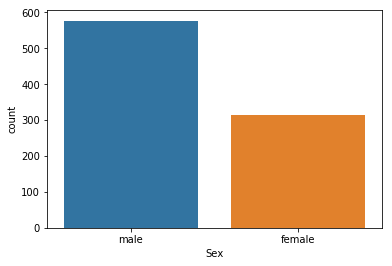

In [6]:
#number of males and females
sns.countplot(train['Sex'])

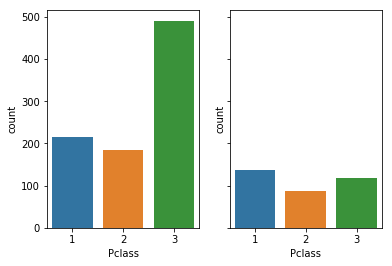

In [7]:
#We will compare the features one by one with the Survived column
#Using the chart, it can be seen that the Pclass=3 are less survived
fig,ax = plt.subplots(1,2,sharex='col',sharey='row')
a = sns.countplot(x='Pclass',data=train,ax=ax[0])
b = sns.countplot(x='Pclass',data=train[train['Survived']==1],ax=ax[1])
length_age = train['Age'].notnull().sum()


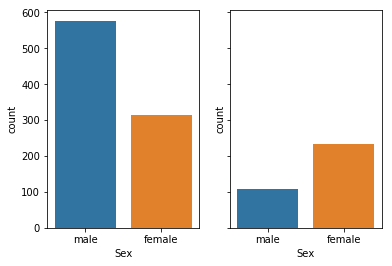

In [8]:
#By comparing the sex with surivived, we can see that most of the females are survived
fig,ax=plt.subplots(1,2,sharex='col',sharey='row')
a=sns.countplot(x='Sex',data=train,ax=ax[0])
b=sns.countplot(x='Sex',data=train[train['Survived']==1],ax=ax[1],order=('male','female'))

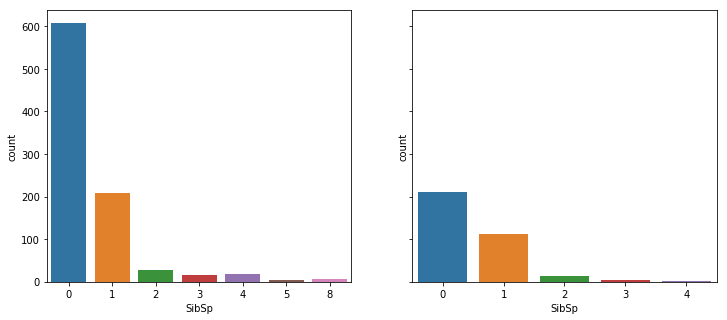

In [9]:
#Comparing SibSp with Survived column, passengers who has no siblings died around 2/3
fig,ax=plt.subplots(1,2,figsize=(12,5),sharex='col',sharey='row')
a=sns.countplot(x='SibSp',data=train,ax=ax[0])
b=sns.countplot(x='SibSp',data=train[train['Survived']==1],ax=ax[1])

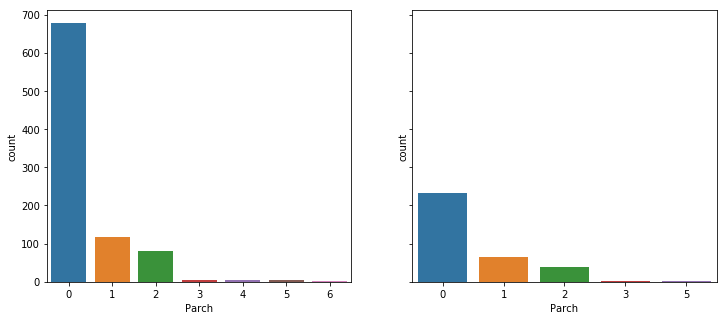

In [10]:
#Comparing Parch with Survived column,passengers with parent/children died around 2/3 
fig,ax=plt.subplots(1,2,figsize=(12,5),sharex='col',sharey='row')
a=sns.countplot(x="Parch",data=train,ax=ax[0])
b=sns.countplot(x="Parch",data=train[train['Survived']==1],ax=ax[1])

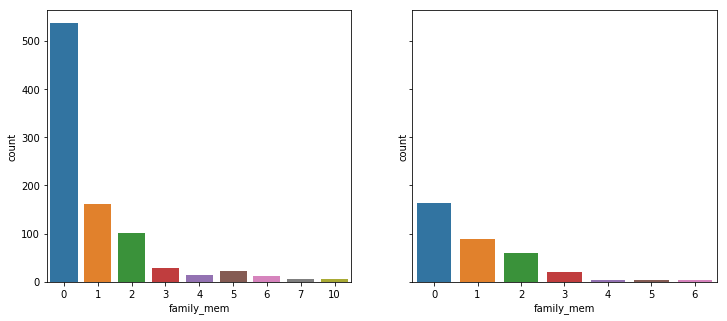

In [11]:
#More males were died based on representation of bar chart using 'Sex' column. Predicting the numbers of passengers 
#with and without any family members, help us to analyze how the family members affected the survival rate of passengers 
#Passengers with 0 family members are more in number, but their survival rate is less
train['family_mem']=train['Parch']+train['SibSp']  #count of the family members by adding 'Parch' and 'SibSp'
test['family_mem']=test['Parch']+test['SibSp']
train.drop(['Parch','SibSp'],axis=1)
test.drop(['Parch','SibSp'],axis=1)
fig,ax=plt.subplots(1,2,figsize=(12,5),sharex='col',sharey='row')
a=sns.countplot(x='family_mem',data=train,ax=ax[0])
b=sns.countplot(x='family_mem',data=train[train['Survived']==1],ax=ax[1])

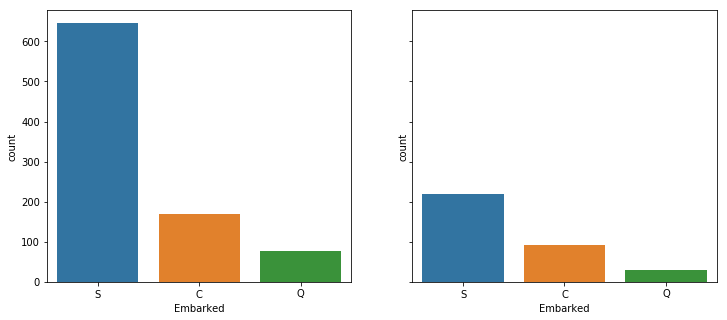

In [12]:
#Comparison between 'Embarked' and 'Survival', the passengers from the 'S' died the most
fig,ax=plt.subplots(1,2,figsize=(12,5),sharex='col',sharey='row')
a = sns.countplot(x='Embarked',data=train,ax=ax[0])
b = sns.countplot(x='Embarked',data=train[train['Survived']==1],ax=ax[1],order=['S','C','Q'])

In [13]:
 #Now we have to fill the empty spaces of 'Age' using the features    
l=train.groupby(['Sex','Survived'])    
Name=train['Name']
L,Title=[],[""]*891
for i in range(len(train)):
    s=Name[i].split(",")[1].split(".")[0]
    s=s[1:len(s)]
    Title[i]=s
    if(s not in L):
        L.append(s)
print(L,len(L))     
train["title"]=Title  
test["title"]=test.Name.apply(lambda x:x.split('.')[0].split(',')[1].strip())
train["title"].head()    


['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess', 'Jonkheer'] 17


0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: title, dtype: object

In [14]:
train.groupby(['Pclass','Sex']).Age.mean()

Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64

In [15]:
def newage (cols):
    Pclass=cols[0]
    Sex=cols[1]
    Age=cols[2]
    if pd.isnull(Age):
        if Pclass==1 and Sex=="male":
            return 41.3
        elif Pclass==1 and Sex=='female':
            return 34.6
        elif Pclass==2 and Sex=='male': 
            return 30.74
        elif Pclass==2 and Sex=='female':
            return 28.7
        elif Pclass==3 and Sex=='male':
            return 26.5
        elif Pclass==3 and Sex=='female':
            return 21.8
    else:
        return Age 

In [16]:
train.Age=train[['Pclass','Sex','Age']].apply(newage, axis=1)
test.Age=test[['Pclass','Sex','Age']].apply(newage,axis=1)

In [17]:

train['Name2']=train.Name.apply(lambda x: x.split(',')[0].strip())
train['Name2'].head()

0       Braund
1      Cumings
2    Heikkinen
3     Futrelle
4        Allen
Name: Name2, dtype: object

In [18]:
train.drop(['PassengerId','Name','Ticket','Cabin'],axis=1,inplace=True)
test.drop(['PassengerId','Name','Ticket','Cabin'],axis=1,inplace=True)

In [19]:
titanic = pd.concat([train,test],sort=False)
titanic = pd.get_dummies(titanic)
train = titanic[:len_train]
test = titanic[len_train:]
xtrain=train.drop("Survived",axis=1)
ytrain=train['Survived']
xtest=test.drop("Survived", axis=1)
svc=make_pipeline(StandardScaler(),SVC(random_state=1))
r=[0.0001,0.001,0.1,1,10,50,100]
PSVM=[{'svc__C':r, 'svc__kernel':['linear']},
      {'svc__C':r, 'svc__gamma':r, 'svc__kernel':['rbf']}]
GSSVM=GridSearchCV(estimator=svc, param_grid=PSVM, scoring='accuracy', cv=2)
scores_svm=cross_val_score(GSSVM, xtrain.astype(float), ytrain,scoring='accuracy', cv=5)

In [20]:
np.mean(scores_svm)

0.843994280419053

In [21]:
model = GSSVM.fit(xtrain,ytrain)
pred = model.predict(xtest)
for i in pred:
    i=int(i)
print(pred)    
output = pd.DataFrame({'PassengerId':test2['PassengerId'],'Survived':pred})
output.to_csv('submission.csv', index=False)


[0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0.
 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0.
 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1.
 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0.
 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.